In [1]:
import sxsc_tushare as sx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import *
from numpy.linalg import multi_dot
sx.set_token("0a3191104cd108eccc6d1d4ce8a431f8d99fb786926e5d788f3b55c5")#因为这个账号是私有的 所以老师我无法把真实通行token给到你
pro = sx.get_api(env="prd")

In [2]:
df = pro.daily( ts_code = ' 600298.SH, 600872.SH, 600186.SH', start_date='20041231', end_date='20241231', )
df.head(10)

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600872.SH,20241231,22.90,22.95,21.97,22.02,22.88,-0.86,-3.7587,128218.61,286369.862
1,600298.SH,20241231,36.26,36.57,36.05,36.05,36.26,-0.21,-0.5792,46909.80,170140.988
2,600186.SH,20241231,5.02,5.70,4.92,5.70,5.18,0.52,10.0386,2546273.82,1386903.837
3,600186.SH,20241230,5.39,5.39,5.11,5.18,4.90,0.28,5.7143,1863664.92,980407.231
4,600298.SH,20241230,36.32,36.71,36.10,36.26,36.37,-0.11,-0.3024,41062.20,149470.040
5,600872.SH,20241230,23.27,23.36,22.75,22.88,23.26,-0.38,-1.6337,113979.32,261826.508
6,600872.SH,20241227,23.31,23.43,22.98,23.26,23.27,-0.01,-0.0430,87356.00,202761.922
7,600298.SH,20241227,35.90,36.55,35.83,36.37,35.97,0.40,1.1120,43404.66,157068.130
8,600186.SH,20241227,4.83,5.01,4.75,4.90,4.78,0.12,2.5105,529206.00,259854.243
9,600186.SH,20241226,4.70,4.84,4.67,4.78,4.74,0.04,0.8439,366488.89,175079.632


In [3]:
df['trade_date'] = pd.to_datetime(df['trade_date'], format='%Y%m%d')
# df = df.sort_values('trade_date' )ascending = True
df = df.sort_values('trade_date', ascending=True)

In [4]:
df_filtered = df[['ts_code', 'trade_date', 'close']]

In [5]:
df_filtered

,ts_code,trade_date,close
5999,600186.SH,2016-10-11,5.50
5996,600298.SH,2016-10-12,16.92
5998,600186.SH,2016-10-12,5.46
5997,600872.SH,2016-10-12,14.99
5993,600186.SH,2016-10-13,5.53
...,...,...,...
4,600298.SH,2024-12-30,36.26
3,600186.SH,2024-12-30,5.18
2,600186.SH,2024-12-31,5.70
1,600298.SH,2024-12-31,36.05


In [6]:
df_pivot = df_filtered.pivot(
    index='trade_date',   # 行索引为日期
    columns='ts_code',    # 列索引为股票代码
    values='close'        # 填充值为收盘价
)



In [7]:
df_pivot 

ts_code,600186.SH,600298.SH,600872.SH
trade_date,,,
2016-10-11,5.50,NaN,NaN
2016-10-12,5.46,16.92,14.99
2016-10-13,5.53,17.05,14.98
2016-10-14,5.52,16.96,15.69
2016-10-17,5.41,17.30,15.44
...,...,...,...
2024-12-25,4.74,35.44,23.12
2024-12-26,4.78,35.97,23.27
2024-12-27,4.90,36.37,23.26


In [8]:
df_filled = df_pivot.fillna(method='bfill', axis=0)
df_filled


C:\Users\perco\AppData\Local\Temp\ipykernel_25724\3706142441.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = df_pivot.fillna(method='bfill', axis=0)


ts_code,600186.SH,600298.SH,600872.SH
trade_date,,,
2016-10-11,5.50,16.92,14.99
2016-10-12,5.46,16.92,14.99
2016-10-13,5.53,17.05,14.98
2016-10-14,5.52,16.96,15.69
2016-10-17,5.41,17.30,15.44
...,...,...,...
2024-12-25,4.74,35.44,23.12
2024-12-26,4.78,35.97,23.27
2024-12-27,4.90,36.37,23.26


In [9]:
returns = np.log(df_filled/df_filled.shift(1)).dropna()

returns.shape

(2001, 3)

In [10]:
# 组合的股票构成

symbols = ['600186.SH','600298.SH','600872.SH']
numofasset = len(symbols)
 
# 定义一个组合的函数
def portfolio_simulation(returns):
    rets = []; vols=[]; wts=[]
    
    # 模拟10000次3只股票不同权重的组合
    for i in tqdm(range(10000)):
        # 产生随机权重
        weights = np.random.random(numofasset)[:, np.newaxis]
        weights = weights/weights.sum()
        
        # 记录组合的收益、波动、权重
        rets.append(weights.T @ np.array(returns.mean()*250)[:,np.newaxis])
        vols.append(np.sqrt(multi_dot([weights.T, returns.cov()*250, weights])))
        wts.append(weights.flatten())
        
    # 记录组合各数据
    portdf =  pd.DataFrame({
        'port_rets': np.array(rets).flatten(),
        'port_vols': np.array(vols).flatten(),
        'weights': list(np.array(wts))
        })
    portdf['Sharp_ratio']=(portdf['port_rets']-0.02)/(portdf['port_vols'])  #假设rf为0
    
    return round(portdf, 2)

temp = portfolio_simulation(returns)
temp.head(10)

100%|██████████| 10000/10000 [00:12<00:00, 777.94it/s]


,port_rets,port_vols,weights,Sharp_ratio
0,0.03,0.32,"[0.5060476799962363, 0.007156534978816947, 0.4...",0.02
1,0.04,0.30,"[0.4267701253487204, 0.15029003686922374, 0.42...",0.05
2,0.06,0.29,"[0.20162590800600028, 0.4286058477404424, 0.36...",0.14
3,0.07,0.29,"[0.23076051022067112, 0.6595286279686065, 0.10...",0.17
4,0.05,0.29,"[0.29365283681458676, 0.24347681282062036, 0.4...",0.09
5,0.07,0.31,"[0.03297169130537357, 0.5654692762764, 0.40155...",0.17
6,0.05,0.29,"[0.4002471966508565, 0.5021157033464708, 0.097...",0.12
7,0.03,0.31,"[0.39281670666489854, 0.06504001075191339, 0.5...",0.04
8,0.05,0.29,"[0.2889123527476331, 0.3037770301827229, 0.407...",0.10
9,0.07,0.30,"[0.11723173880042441, 0.4954821095711401, 0.38...",0.15


In [11]:
temp.iloc[temp.Sharp_ratio.idxmax()]

port_rets                                                   0.09
port_vols                                                   0.34
weights        [0.01918143444931867, 0.9457217486620781, 0.03...
Sharp_ratio                                                 0.21
Name: 397, dtype: object

D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33945 (\N{CJK UNIFIED IDEOGRAPH-8499}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site

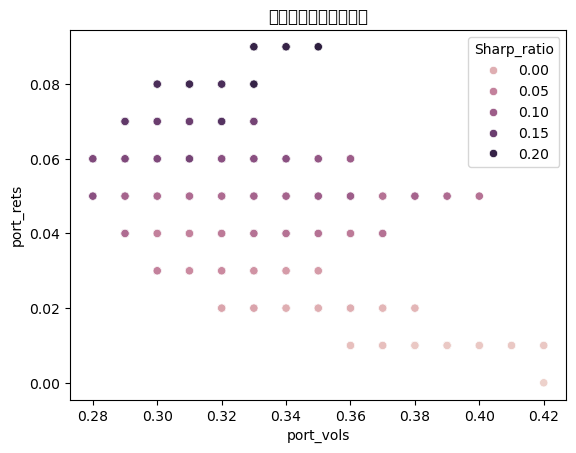

In [12]:
import seaborn as sns
sns.scatterplot(data=temp, x='port_vols', y='port_rets', hue='Sharp_ratio')
plt.title('投资组合蒙特卡洛模拟')
plt.show()




In [13]:
# weights( 0.013,0.973,0.014) 归一化最优夏普
weights_dict = {'600186.SH': 0.013, '600298.SH': 0.973, '600872.SH': 0.014}
result = df_filled[weights_dict.keys()].dot(pd.Series(weights_dict))
result

trade_date
2016-10-11    16.74452
2016-10-12    16.74400
2016-10-13    16.87126
2016-10-14    16.79350
2016-10-17    17.11939
                ...   
2024-12-25    34.86842
2024-12-26    35.38673
2024-12-27    35.77735
2024-12-30    35.66864
2024-12-31    35.45903
Length: 2002, dtype: float64

In [14]:
# expect shortfall
returns = np.log(result/result.shift(1)).dropna()
returns = returns.sort_values(ascending = True)

In [15]:
VAR10 = returns.head(200).mean()

In [16]:
VAR10
# 90%置信度

-0.03932793864485423

In [17]:
VAR5 = returns.head(100).mean()

In [18]:
VAR5
# 95%置信度

-0.05008475734969926

In [19]:
returns.mean()

0.00037496596948719994

In [40]:
returns.std()

0.022320601272101018

In [42]:
VAR_by_normaldistribution = returns.mean() - returns.std()

In [44]:
VAR_by_normaldistribution


-0.021945635302613817